## В данной работе будет проанализирован A/B-тест мобильной игры

#### Импортируем необходимые библиотеки

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import random
rng = random.Random(42)

#### Загрузим данные и посмотрим на них

In [6]:
# Загружаем данные
cats = pd.read_csv("cookie_cats.csv")

In [8]:
# Выведем первые 5 строк
cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


#### Значения столбцов:
- userid - уникальный идентификатор пользователя;
- version - группа пользователя, gate_30 (контрольная), gate_40 (тестовая);
- sum_gamerounds - количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки;
- retention_1 - вернулся ли пользователь на следующий день полсе установки;
- retention_7 - вернулся ли пользователь через 7 дней полсе установки

In [11]:
# Посмотрим информацию о количестве не нулевых значений
cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


#### Теперь рассмотрим задания, которые можно выполнить:
1. Проанализировать метрики
2. Проанализировать A/B-тест по различным показателям

### Для более показательного анализа дополним исходные данные двумя столбцами, которые будут псевдорандомно заполнены:
- buy_content - совершил ли пользователь покупку или нет;
- revenue - если клиент совершил покупку, то значение равно цене покупки, иначе 0.

In [15]:
# Создадим столбец buy_content
cats['buy_content'] = cats.apply(lambda row: True if row.userid % 10 >= 5 else False, axis=1)

In [16]:
cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7,buy_content
0,116,gate_30,3,False,False,True
1,337,gate_30,38,True,False,True
2,377,gate_40,165,True,False,True
3,483,gate_40,1,False,False,False
4,488,gate_40,179,True,True,True


In [17]:
def give_revenue(ret_1, ret_7):
    revenue_variants = [299, 599, 999]
    if ret_1:
        if ret_7:
            return revenue_variants[2]
        else:
            return revenue_variants[1]
    else:
        return revenue_variants[0]

In [18]:
# Создадим массив с возможными ценами на продукты игры, а затем применим функцию для выдачи одной из цен
cats['revenue'] = cats.apply(lambda row: give_revenue(row['retention_1'], row['retention_7']) if row['buy_content'] else 0, axis=1)

In [19]:
# Полученный датафрейм
cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7,buy_content,revenue
0,116,gate_30,3,False,False,True,299
1,337,gate_30,38,True,False,True,599
2,377,gate_40,165,True,False,True,599
3,483,gate_40,1,False,False,False,0
4,488,gate_40,179,True,True,True,999


# Часть I. Рассмотрим изначальные данные
#### Попробуем найти закономерности и посмотрим описательные статистики
#### Сначала посмотрим на sum_gamerounds

In [22]:
# Посмотрим описательные статистики
cats.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Видно, что есть достаточно огромный выброс, который явно завышает среднее. Посмотрим на него и удалим, чтобы он не исказил дальнейший анализ

In [26]:
# Посмотрим на топ 5 пользователей, которые сыграли больше всего раундов
cats.sort_values('sum_gamerounds', ascending=False).head(5)

,userid,version,sum_gamerounds,retention_1,retention_7,buy_content,revenue
57702,6390605,gate_30,49854,False,True,True,299
7912,871500,gate_30,2961,True,True,False,0
29417,3271615,gate_40,2640,True,False,True,599
43671,4832608,gate_30,2438,True,True,True,999
48188,5346171,gate_40,2294,True,True,False,0


In [27]:
# Возьмем пользователя с аномальным количеством раундов и удалим его из таблицы
anomal_player = cats.sort_values('sum_gamerounds', ascending=False).head(1)
cats_new = cats.drop(anomal_player.index)

#### Теперь посмотрим на распределение этой велечины

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

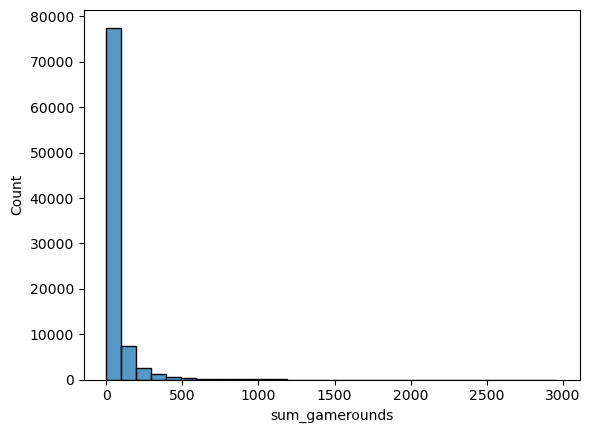

In [29]:
# Построим гистограмму
sns.histplot(data=cats_new, x='sum_gamerounds', bins=30)

#### Видно, что распределение сильно отличается от нормального, что вполне естественно. Попробуем прологарифмировать, предварительно убрав нулевые значения

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

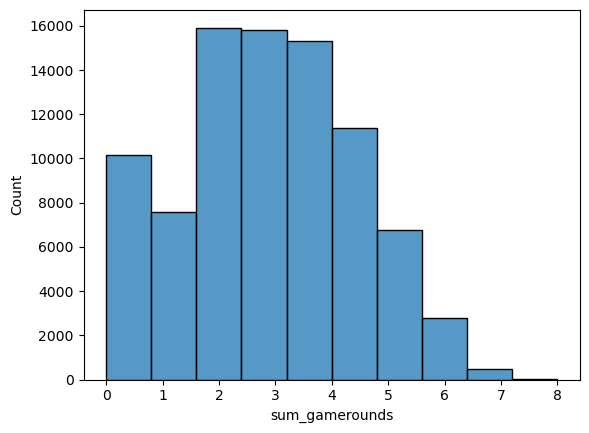

In [34]:
# Построим гистограмму
active_rounds = cats_new.query('sum_gamerounds != 0')
sns.histplot(data=active_rounds, x=np.log(active_rounds.sum_gamerounds), bins=10)

#### Получается логнормальное распределение данных, с которым уже можно работать
#### Посотрим на матрицу корреляций относительно количества сыгранных раундов, ретеншена первого и седьмого дня

In [38]:
# Построим матрицу корреляций
cats_new[['sum_gamerounds', 'retention_1', 'retention_7']].corr()

,sum_gamerounds,retention_1,retention_7
sum_gamerounds,1.000000,0.380178,0.519288
retention_1,0.380178,1.000000,0.327431
retention_7,0.519288,0.327431,1.000000


#### Видно, что существует умеренная положительная корреляция между всеми элементами. Поэтому можно сделать вывод, что количество сыгранных раундов зависит от возвращения игроков на 1-й и 7-й дни, но не сильно.
#### Теперь рассмотрим различные метрики по группам

In [41]:
# Разделим данные по группам
control = cats_new.query('version == "gate_30"')
test = cats_new.query('version == "gate_40"')

#### Посмотрим на количество сыгранных раундов по группам

In [45]:
# Описательные статистики контрольной группы
control.sum_gamerounds.describe()

count    44699.000000
mean        51.342111
std        102.057598
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

In [48]:
# Описательные статистики тестовой группы
test.sum_gamerounds.describe()

count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64

#### Размеры выборок почти одинаковые, да и статистики похожи друг на друга. Посмотрим на распределения

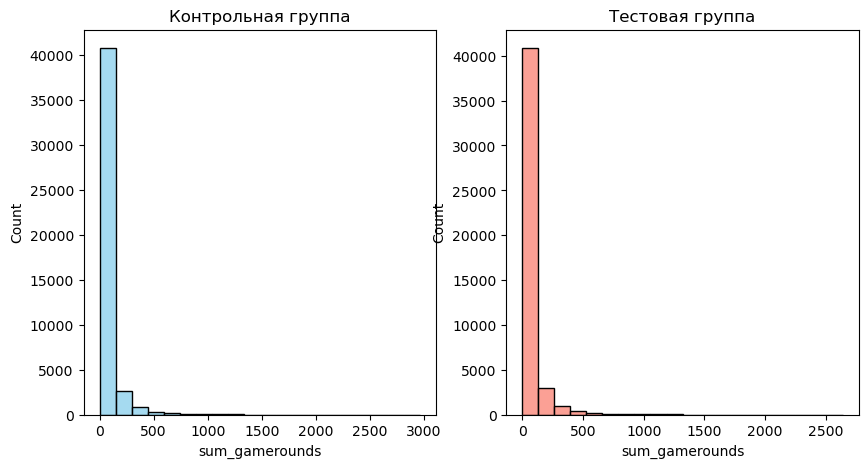

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Строим гистограмму для первого распределения
sns.histplot(control.sum_gamerounds, ax=ax1, color='skyblue', bins=20)
ax1.set_title('Контрольная группа')

# Строим гистограмму для второго распределения
sns.histplot(test.sum_gamerounds, ax=ax2, color='salmon', bins=20)
ax2.set_title('Тестовая группа')

# Отображаем график
plt.show()

#### Графики почти идентичны между собой и с общим распределением. Прологарифмируем их, убрав нули

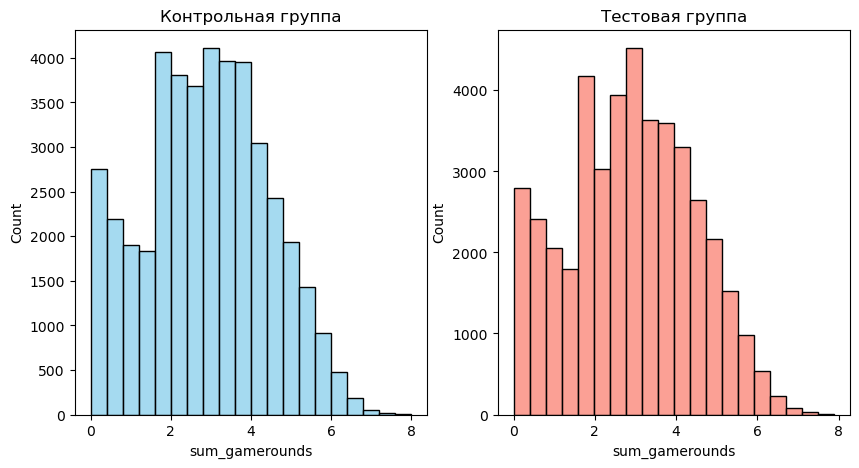

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Строим гистограмму для первого распределения
sns.histplot(np.log(control.query('sum_gamerounds != 0').sum_gamerounds), ax=ax1, color='skyblue', bins=20)
ax1.set_title('Контрольная группа')

# Строим гистограмму для второго распределения
sns.histplot(np.log(test.query('sum_gamerounds != 0').sum_gamerounds), ax=ax2, color='salmon', bins=20)
ax2.set_title('Тестовая группа')

# Отображаем график
plt.show()

#### Теперь статистически проверим выборки на равность дисперсий. Для этого воспользуемся тестом Левена, в котором:
##### H<sub>0</sub> - Дисперсии равны
##### H<sub>1</sub> - Дисперсии отличаются

In [56]:
# Применим тест Левена
ss.levene(control.sum_gamerounds, test.sum_gamerounds)

LeveneResult(statistic=0.07510153837481241, pvalue=0.7840494387892463)

#### Дисперсии отличаются не значимо
#### Теперь проверим, есть ли отличия в средних значениях в каждой группе и являются ли они статистически значимыми. Для этого возьмем критерий Манна-Уитни, так как у нас есть сильные отличия от нормальности (однако t-тест тоже справился с этой задачей), у которого:
#### H<sub>0</sub> - Распределения в двух выборках идентичны
#### H<sub>1</sub> - Распределения отличаются
#### Уровень значимости возьмем 0.05

In [60]:
# Применим критерий Манна-Уитни
ss.mannwhitneyu(control.sum_gamerounds, test.sum_gamerounds)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

#### Получаем p-value чуть больше чем 0.05, что не позволяет отвергнуть нулевую гипотезу

## Вывод: проанализировав A/B-тест по количеству сыгранных раундов можно сказать, что тестовая и контрольные группы статистически значимо не различаются.

### Теперь посмотрим на ретеншн 1-го и 7-го дня

In [65]:
# Посчитаем общее количество пользователей
num_all_control = control.userid.nunique()
num_all_test    = test.userid.nunique()

In [67]:
# Найдем количество вернувшихся пользователей на 1-й день
num_return_1_control = control.query('retention_1 == True').userid.nunique()
num_return_1_test    = test.query('retention_1 == True').userid.nunique()
# Рассчитаем retention для 1-го дня
pct_1_control          = np.round(num_return_1_control / num_all_control * 100, 2)
pct_1_test             = np.round(num_return_1_test / num_all_test * 100, 2)

In [69]:
# Найдем количество вернувшихся пользователей на 7-й день
num_return_7_control = control.query('retention_7 == True').userid.nunique()
num_return_7_test    = test.query('retention_7 == True').userid.nunique()
# Рассчитаем retention для 7-го дня
pct_7_control          = np.round(num_return_7_control / num_all_control * 100, 2)
pct_7_test             = np.round(num_return_7_test / num_all_test * 100, 2)

In [71]:
pd.DataFrame([[num_all_control, num_return_1_control, num_return_7_control, pct_1_control, pct_7_control], [num_all_test, num_return_1_test, num_return_7_test, pct_1_test, pct_7_test]], 
            columns=['unique_users', 'returned_users_1', 'returned_users_7', 'retention_1', 'retention_7'], index=['control', 'test'])

,unique_users,returned_users_1,returned_users_7,retention_1,retention_7
control,44699,20034,8501,44.82,19.02
test,45489,20119,8279,44.23,18.20


#### Смотря на таблицу, можно сказать, что значения retention-ов не сильно отличаются друг от друга. Получается, изменения в тестовой группе почти ни как не влияет на возвращаемость игороков на 1-й и 7-й дни.

# Часть II. Теперь проанализируем данные, которые были искусственно сгенерированы

In [75]:
# Еще раз посмотрим на данные
cats_new.head()

,userid,version,sum_gamerounds,retention_1,retention_7,buy_content,revenue
0,116,gate_30,3,False,False,True,299
1,337,gate_30,38,True,False,True,599
2,377,gate_40,165,True,False,True,599
3,483,gate_40,1,False,False,False,0
4,488,gate_40,179,True,True,True,999


In [77]:
# Посмотрим на количество игороков, которые купили контент в игре
print(f'Количество игороков, котоыре купили контент, равно: {cats_new.buy_content.sum()}')
print(f'Количество игороков, котоыре не купили контент, равно: {cats_new.buy_content.count() - cats_new.buy_content.sum()}')

Количество игороков, котоыре купили контент, равно: 45252
Количество игороков, котоыре не купили контент, равно: 44936


#### Опять же равенство. Посмотрим то же самое только по группам 

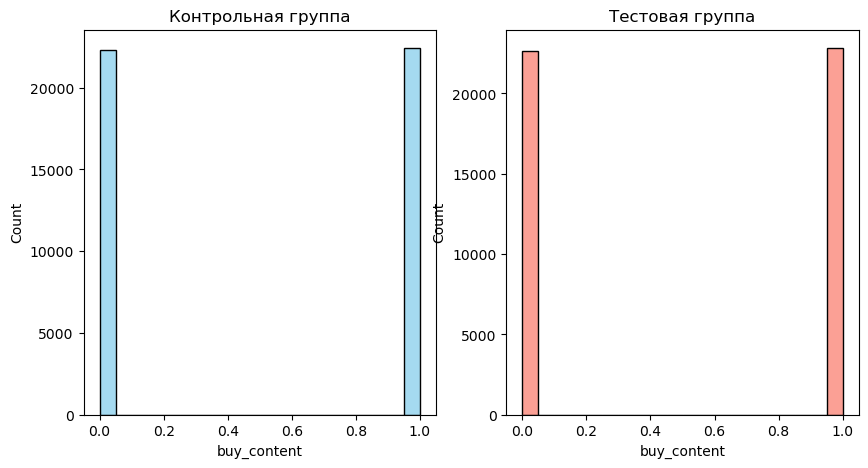

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Строим гистограмму для первого распределения
sns.histplot(control, x='buy_content', ax=ax1, color='skyblue', bins=20)
ax1.set_title('Контрольная группа')

# Строим гистограмму для второго распределения
sns.histplot(test, x='buy_content', ax=ax2, color='salmon', bins=20)
ax2.set_title('Тестовая группа')

# Отображаем график
plt.show()

#### Теперь рассмотрим показатель выручки. Выведем описательные статистики

In [82]:
# Посмотрим описательные статистики выручки контрольной группы
control.revenue.describe()

count    44699.000000
mean       247.034095
std        302.906226
min          0.000000
25%          0.000000
50%        299.000000
75%        299.000000
max        999.000000
Name: revenue, dtype: float64

In [85]:
# Посмотрим описательные статистики выручки тестовой группы
test.revenue.describe()

count    45489.000000
mean       245.830223
std        300.958360
min          0.000000
25%          0.000000
50%        299.000000
75%        299.000000
max        999.000000
Name: revenue, dtype: float64

#### Построим boxplot-ы для каждой группы

<Axes: ylabel='revenue'>

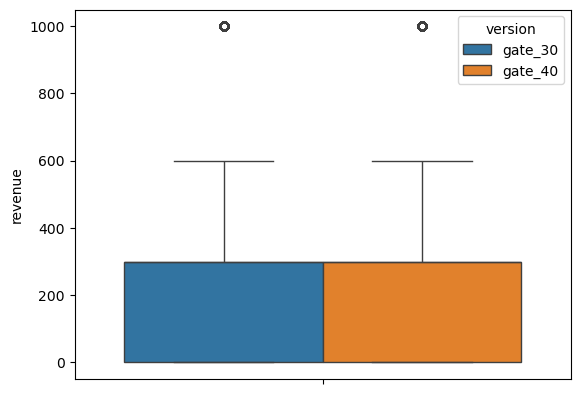

In [88]:
sns.boxplot(cats_new, hue='version', y='revenue')

#### Все очень близко друг к другу, что и следовало ожидать. И для того чтобы окончательно в этом убедиться проверим выборки на равенство средних с помощью т-теста, в котором:
#### H<sub>0</sub> - Среднее в двух выборках идентичны
#### H<sub>1</sub> - Среднее отличаются
#### Уровень значимости возьмем 0.05

In [90]:
ss.ttest_ind(control.revenue, test.revenue)

TtestResult(statistic=0.598698943877956, pvalue=0.5493751652797159, df=90186.0)

#### p-value значительно больше 0.05, что не позволяет нам отклонить нулевую гипотезу, а это значит, что средние значения выручки в двух выборках равны

# Выводы

### Проанализировав данные мобильной игры, можно сделать следующие выводы: проведенный A/B-тест не принес ощутимого результата. Метрики сыгранных раундов, а также retention 1-го и 7-го дня практически ни как не изменились. Статистически доказано, что данный эксперимент нельзя запускать на всех пользователей и нуждается в доработке.
### Также были введены искусственные данные покупался ли контент игроками и за какую сумму. Проанализировав и эти данные, результат остался неизменным: количество игроков, которые купили какой-либо контент не увеличилось, собственно как и выручка.
### Можно с уверенностью утверждать, что этот эксперимент провалился